In [1]:
# imports
from astropy.io import fits
from scipy import interpolate as sin
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotting as myP
import numpy as np
import csv 
import match
import SED
from astropy.cosmology import FlatLambdaCDM

In [2]:
# path variables 
path_cat = 'D:\IfA REU\Catalogs'
path_fig = 'D:\IfA REU\IfA-REU-Project\Figures'
path_csv = 'D:\IfA REU\IfA-REU-Project\Lists'

# Read Data

In [3]:
# read AGN IDs
agnIDs = myP.ReadFile(path_csv+'\ID_RedYelBlu_AGNselection.csv')

# convert agnIDs into list of integer numpy arrays 
agnIDs_npArray = []
for row in agnIDs : 
    agnIDs_npArray.append(np.array(row, dtype=int))

Cropped:  ['Row 1 = red IR selected AGN. Row 2 = yellow both IR-Xray AGN. Row 3 = blue X-ray selected AGN. Row 4 = blue X-ray selected AGN with IRAC detections. Row 5 = blue X-ray selected AGN without IRAC detections. Row 6 = red IR selected AGN with 24um detection. Row 7 = yellow both IR-Xray AGN with 24um detection. Row 8 = blue X-ray selected AGN with 24um and IRAC detections. Values are ID_COSMOS2015.']


In [4]:
# constants for AGN type index

RED = 0     # red       IR selected AGN
YEL = 1     # yellow    both IR-Xray AGN
BLU = 2     # blue      X-ray selected AGN

BYI = 3     # blue      X-ray selected AGN  with IRAC detections
BNI = 4     # blue      X-ray selected AGN  without IRAC detections

R24 = 5     # red       IR selected AGN     with 24um detection
Y24 = 6     # yellow    both IR-Xray AGN    with 24um detection
B24 = 7     # blue      X-ray selected AGN  with 24um and IRAC detections

In [5]:
# setup corresponding color
agn_colors = [myP.c_ir, myP.c_ir_xray, myP.c_xray, myP.c_xray, myP.c_xray, myP.c_ir, myP.c_ir_xray, myP.c_xray]

In [6]:
def PrintNumber(myList) : 
    # make list of AGN names for printting info 
    agnTypeNames = ['Red:\t', 'Yel:\t', 'Blu:\t', 'Byi:\t', 'Bni:\t', 'r24:\t', 'y24:\t', 'r24:\t']
    # print name and number of items in list 
    for name, row in zip(agnTypeNames, myList) : 
        print(name, row.shape)

In [7]:
# print number of sources in agnIDs_npArray
PrintNumber(agnIDs_npArray)

Red:	 (547,)
Yel:	 (609,)
Blu:	 (1567,)
Byi:	 (1416,)
Bni:	 (151,)
r24:	 (399,)
y24:	 (501,)
r24:	 (1016,)


In [8]:
# read redshifts
zAll = np.array(myP.ReadFile(path_cat+'\COSMOS_z_matches.csv'))
zID, zZ = zAll.T
# get correct data type
zID = np.array(zID, dtype=int)
zZ  = np.array(zZ,  dtype=float)
# apply mask to remove bad redshifts
mask_z = (zZ >= 0) & (zZ < 99)
zID = zID[mask_z]
zZ  = zZ[mask_z]
# print info
print('Number of sources w/ z:', len(zID))

Cropped:  ['ID', 'z']
Number of sources w/ z: 485793


In [9]:
agn_z = []
agn_ID_wZ = []

for row in agnIDs_npArray : 
    # match redshift against AGN IDs
    key_z_agn, key_agn_z = match.match(zID, row)
    # get redshift array for AGN
    agn_z.append(zZ[key_z_agn])
    # get AGN ID arrays w/ redshifts
    agn_ID_wZ.append(row[key_agn_z])

# PrintNumber(agn_z)

In [10]:
# open COSMOS 2020 catalog file and get data 
inf20 = fits.open(path_cat+'\COSMOS2020_CLASSIC_R1_v2.0_master.fits')
data20 = inf20[1].data
inf20.close()

In [11]:
Fnu_uJy = SED.GetPhotometry(data20)
IDs_all = SED.GetID(data20)
lam_A   = SED.GetObservedWavelengths_A()

Array shape:	 (1720700, 20)
Array shape:	 (1720700,)
Array shape:	 (20,)


In [12]:
agn_Fnu_uJy = []
agn_ID_wZ_wPhot = []

for row in agn_ID_wZ : 
    # match photometry IDs against AGN IDs 
    key_IDall_agn, key_agn_IDall = match.match(IDs_all, row)
    # get photometry for AGN
    agn_Fnu_uJy.append(Fnu_uJy[key_IDall_agn])
    # get AGN arrays with photometry 
    agn_ID_wZ_wPhot.append(row[key_agn_IDall])

# PrintNumber(agn_Fnu_uJy)

In [13]:
agn_lamR_A = []

# convert each AGN type to rest wavelength
for row in agn_z : 
    agn_lamR_A.append(SED.ConvertToRestWavelength(row))

Array shape:	 (547, 20)
Array shape:	 (609, 20)
Array shape:	 (1567, 20)
Array shape:	 (1416, 20)
Array shape:	 (151, 20)
Array shape:	 (399, 20)
Array shape:	 (501, 20)
Array shape:	 (1016, 20)


In [14]:
agn_lamFlam_ergscm2 = []

# convert each AGN type to energy density
for lamR,Fnu in zip(agn_lamR_A, agn_Fnu_uJy) : 
    agn_lamFlam_ergscm2.append(SED.ConvertToEnergyDensity(lamR,Fnu))

Array shape:	 (547, 20)
Array shape:	 (609, 20)
Array shape:	 (1567, 20)
Array shape:	 (1416, 20)
Array shape:	 (151, 20)
Array shape:	 (399, 20)
Array shape:	 (501, 20)
Array shape:	 (1016, 20)


In [15]:
# important arrays
    # agn_lamFlam_ergscm2   energy density in [erg/s/cm2]
    # agn_Fnu_uJy           flux(frequency) in [microJanskys] 
    # agn_lamR_A            rest wavelength in [angstroms]
    # agn_z                 redshifts of sources

In [16]:
# PrintNumber(agn_lamR_A)
# print('\n')
# PrintNumber(agn_Fnu_uJy)
# print('\n')
# PrintNumber(agn_z)
# print('\n')

# Luminosity

In [17]:
def Flux_to_Lum(F,z):
    # 'Function to convert flux to luminosity’’'
    cosmo = FlatLambdaCDM(H0=70, Om0=0.29, Tcmb0=2.725)
    dl = cosmo.luminosity_distance(z).value # Distance in Mpc
    dl_cgs = dl*(3.0856E24) # Distance from Mpc to cm
    # convert flux to luminosity
    L = F*4*np.pi*dl_cgs**2
    return L

In [18]:
def Lum_at1um(lamFlam,lam,z) :
    lum_list = []
    for x,y,z in zip(lam,lamFlam,z) : 
        # interpolate
        f = SED.Interpolate_log(x,y)
        # normalize at 1um
        Fnu_at1um = SED.Flog_X(f,1*1E+4) # 1A * 10^4 = 1um
        # convert to luminosity
        lum = Flux_to_Lum(Fnu_at1um,z)
        lum_list.append(lum)
    SED.PrintShape(lum_list)
    return(lum_list)

In [19]:
agn_lum_1um_ergs = []

for row_lamFlam, row_lamR, row_z in zip(agn_lamFlam_ergscm2, agn_lamR_A, agn_z) :
    # calculate luminosity at 1um for each source
    agn_lum_1um_ergs.append(Lum_at1um(row_lamFlam, row_lamR, row_z))

Array shape:	 (547,)
Array shape:	 (609,)
Array shape:	 (1567,)
Array shape:	 (1416,)
Array shape:	 (151,)
Array shape:	 (399,)
Array shape:	 (501,)
Array shape:	 (1016,)


# Plot Histogram 

In [31]:
def LogLum(lum) : 
    l = np.array(lum) # convert to array
    l = l[l>0] # exclude zeros
    l = np.log10(l) # get log of luminosity
    return(l)

In [37]:
def MeanLineForHist(x,c='k',xtext=0.998, ytext=0.94, horizAlign='right') :
    mean = np.array(x).mean()
    min_ylim, max_ylim = plt.ylim()
    plt.axvline(mean, color=c, linestyle='dashed', linewidth=2)
    plt.text(mean*xtext, max_ylim*ytext, 'Mean: {:.1f}'.format(mean), c=c, horizontalalignment=horizAlign)

In [38]:
def PlotHist_Lum1um(lum_1um, color, saveStr=''): 
    # set style
    myP.SetStyle()

    # plot histogram
    lum = LogLum(lum_1um)
    plt.hist(lum, bins=np.arange(39,48,0.5), color=color)

    # set height to +10% max value
    min_ylim, max_ylim = plt.ylim()
    plt.ylim(ymin=0, ymax=max_ylim+0.1*max_ylim)

    # axis ticks
    plt.xticks([38,39,40,41,42,43,44,45,46,47,48])

    # mean line
    MeanLineForHist(lum,c='k',)

    # set axis lables
    plt.xlabel('$\log( \; L \; [erg \; s^{-1}] \;)$')
    plt.ylabel('Number')

    # print info
    print('Number (all):\t', len(lum_1um))
    print('Number (L>0):\t', len(lum))
    print('Min (log L>0):\t', min(lum))
    print('Max (log L>0):\t', max(lum))
    
    # save
    if(saveStr) :
        myP.save(saveStr)

    # finish
    plt.show()

Number (all):	 399
Number (L>0):	 379
Min (log L>0):	 38.89951228835205
Max (log L>0):	 46.34067517586188


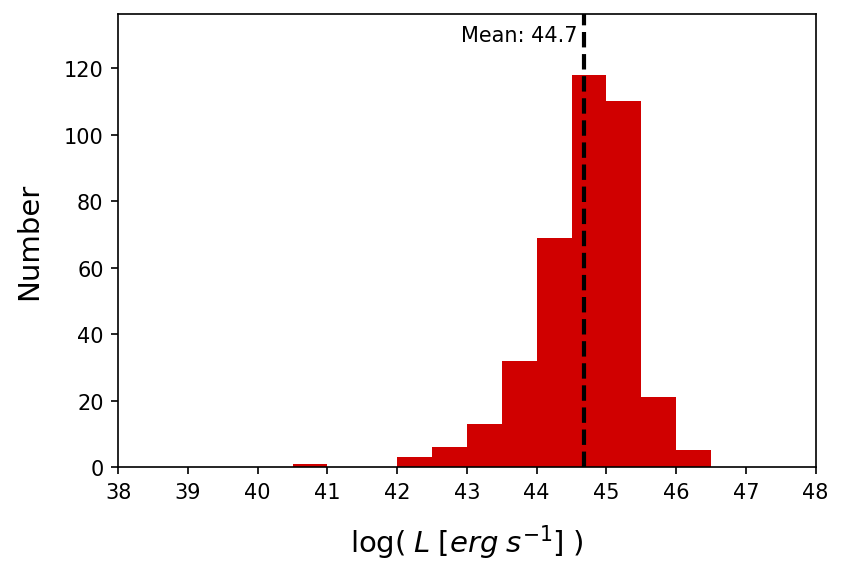

Number (all):	 501
Number (L>0):	 501
Min (log L>0):	 43.237130894920064
Max (log L>0):	 46.59888114005617


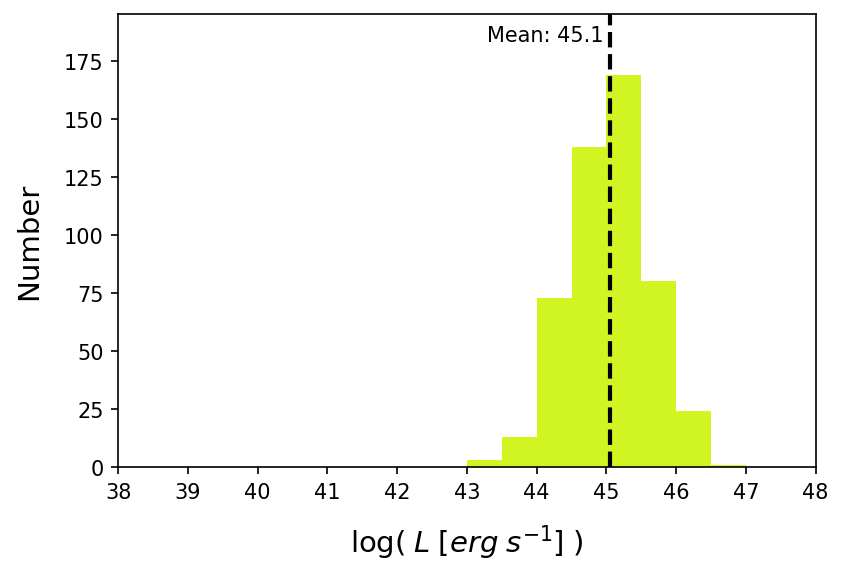

Number (all):	 1016
Number (L>0):	 1016
Min (log L>0):	 43.56332377222411
Max (log L>0):	 47.581250624390506


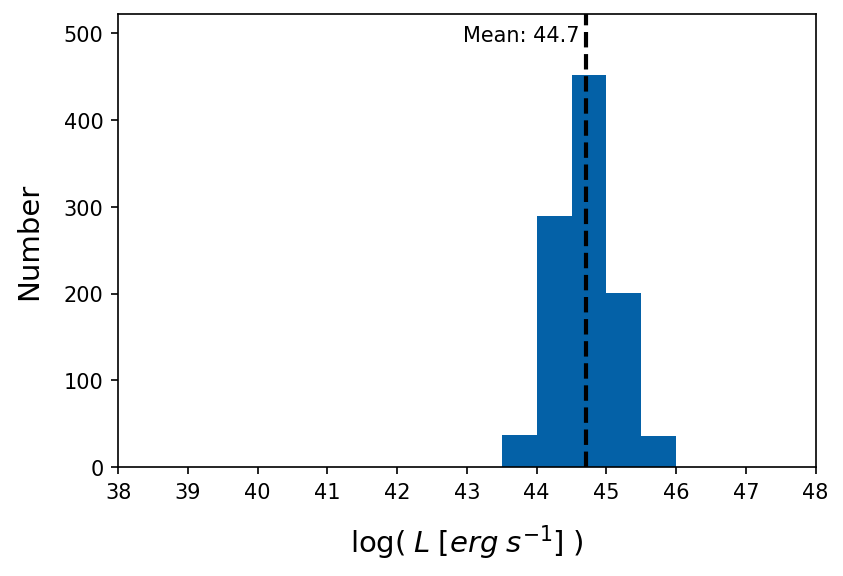

In [39]:
PlotHist_Lum1um(agn_lum_1um_ergs[R24],agn_colors[R24],path_fig+'\COSMOS_luminosityHist_R24.png')
PlotHist_Lum1um(agn_lum_1um_ergs[Y24],agn_colors[Y24],path_fig+'\COSMOS_luminosityHist_Y24.png')
PlotHist_Lum1um(agn_lum_1um_ergs[B24],agn_colors[B24],path_fig+'\COSMOS_luminosityHist_B24.png')

# Plot Z<1

In [35]:
agn_lum_1um_ergs_z01 = []

for z,lum in zip(agn_z, agn_lum_1um_ergs) : 
    #  get mask for redshifts between 0<z<1
    mask = (z > 0) & (z <= 1)
    # convert to array
    lumArr = np.array(lum)
    # get luminosity for 0<z<1 sources
    agn_lum_1um_ergs_z01.append(lumArr[mask])


Number (all):	 61
Number (L>0):	 61
Min (log L>0):	 38.89951228835205
Max (log L>0):	 44.95150363592921


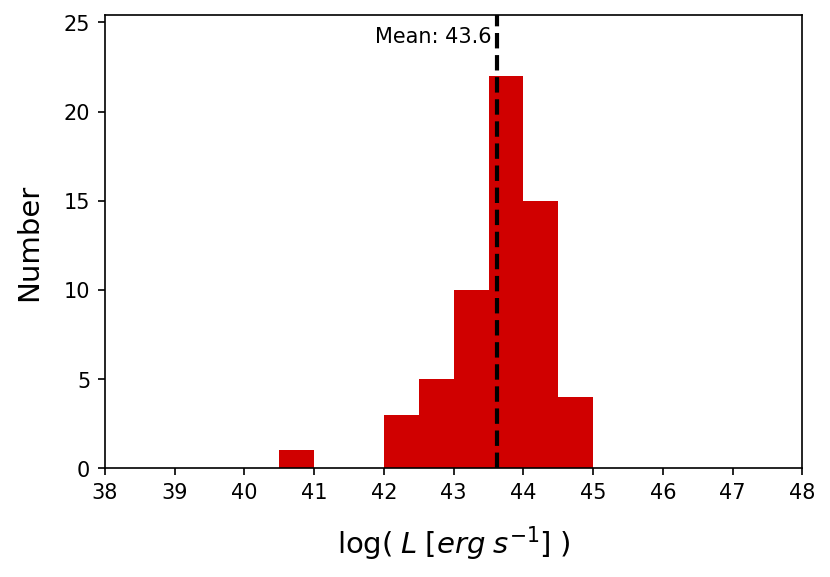

Number (all):	 78
Number (L>0):	 78
Min (log L>0):	 43.237130894920064
Max (log L>0):	 44.98910466958682


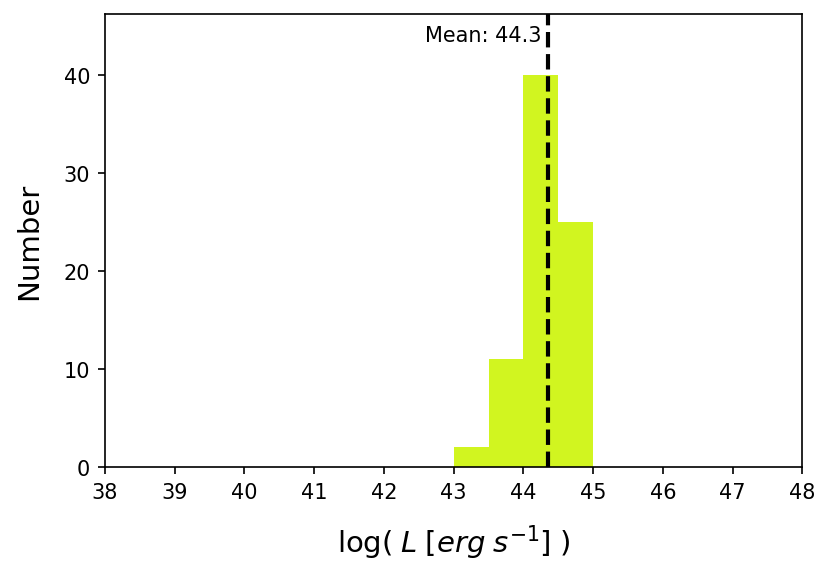

Number (all):	 284
Number (L>0):	 284
Min (log L>0):	 43.56332377222411
Max (log L>0):	 45.370760708337585


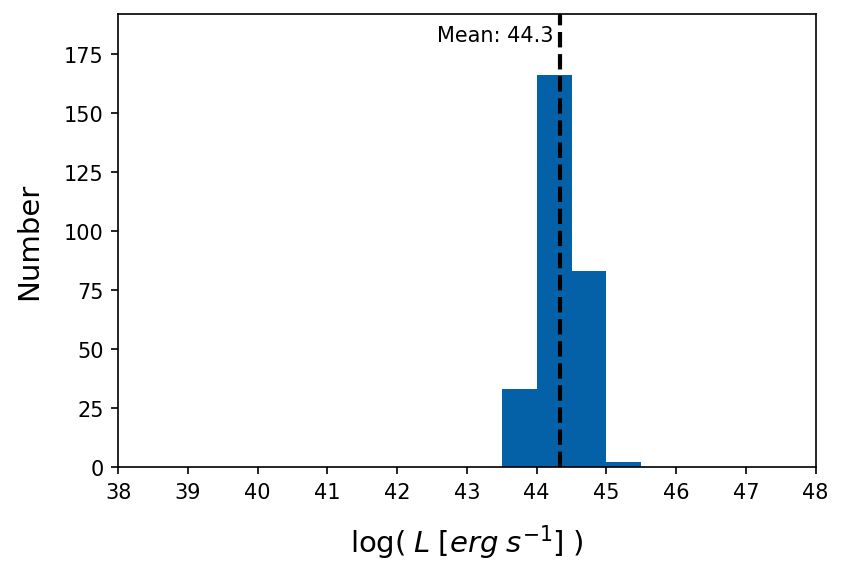

In [40]:
PlotHist_Lum1um(agn_lum_1um_ergs_z01[R24],agn_colors[R24],path_fig+'\COSMOS_luminosityHist_R24_z01.png')
PlotHist_Lum1um(agn_lum_1um_ergs_z01[Y24],agn_colors[Y24],path_fig+'\COSMOS_luminosityHist_Y24_z01.png')
PlotHist_Lum1um(agn_lum_1um_ergs_z01[B24],agn_colors[B24],path_fig+'\COSMOS_luminosityHist_B24_z01.png')

# Triple Histograms

In [62]:

def PlotHist_Lum1um_Triple(
    lum1_1um,c1,
    lum2_1um,c2,
    lum3_1um,c3,
    saveStr='',
    showSum=False
):
    # set style
    myP.SetStyle()

    # get log
    lum1 = LogLum(lum1_1um)
    lum2 = LogLum(lum2_1um)
    lum3 = LogLum(lum3_1um)

    if(showSum):
        lum0 = np.concatenate((lum1,lum2,lum3))
        plt.hist(lum0,bins=np.arange(39,48,0.5), histtype='bar',  color='lightgray', linewidth=2)

    # plot histogram
    plt.hist(lum3,bins=np.arange(39,48,0.5), histtype='step', edgecolor=c3,      linewidth=2)
    plt.hist(lum2,bins=np.arange(39,48,0.5), histtype='step', edgecolor=c2,      linewidth=2)
    plt.hist(lum1,bins=np.arange(39,48,0.5), histtype='step', edgecolor=c1,      linewidth=2)

    # set height to +20% max value
    min_ylim, max_ylim = plt.ylim()
    plt.ylim(ymin=0, ymax=max_ylim+0.20*max_ylim)

    # axis ticks
    plt.xticks([38,39,40,41,42,43,44,45,46,47,48])

    # mean line
    MeanLineForHist(lum1,c=c1,ytext=0.94)
    MeanLineForHist(lum2,c=c2,ytext=0.89)
    MeanLineForHist(lum3,c=c3,ytext=0.84)

    # set axis lables
    plt.xlabel('$\log( \; L \; [erg \; s^{-1}] \;)$')
    plt.ylabel('Number')
    
    # save
    if(saveStr) :
        myP.save(saveStr)

    # finish
    plt.show()

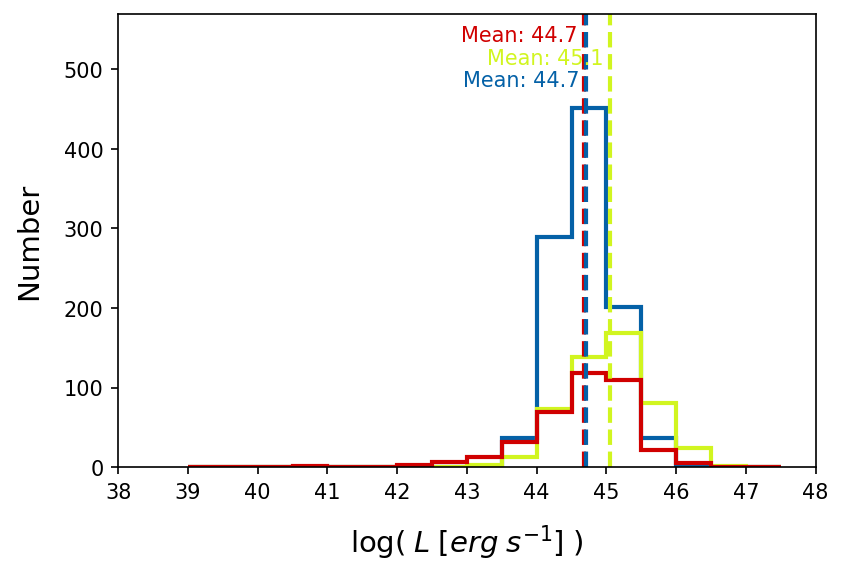

In [63]:
PlotHist_Lum1um_Triple(
    agn_lum_1um_ergs[R24],agn_colors[R24],
    agn_lum_1um_ergs[Y24],agn_colors[Y24],
    agn_lum_1um_ergs[B24],agn_colors[B24],
    path_fig+'\COSMOS_luminosityHist_tri24.png'
)

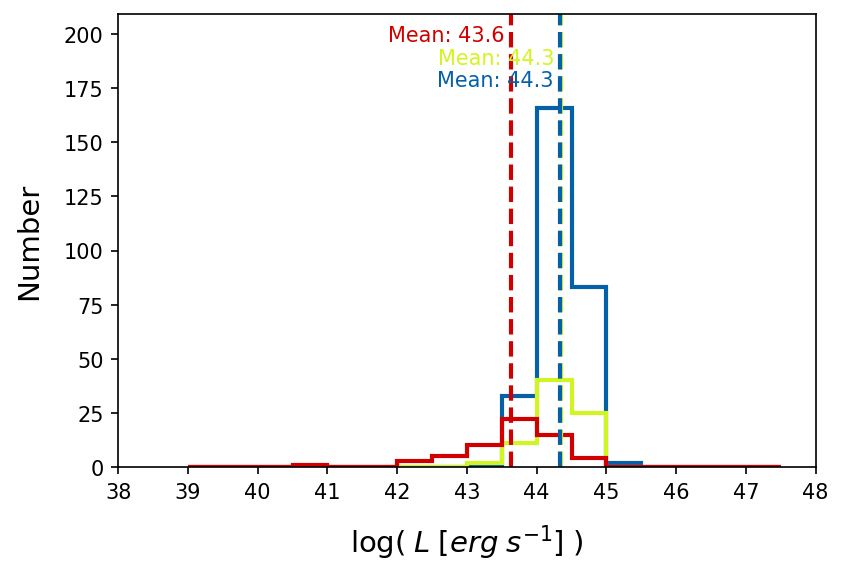

In [64]:
PlotHist_Lum1um_Triple(
    agn_lum_1um_ergs_z01[R24],agn_colors[R24],
    agn_lum_1um_ergs_z01[Y24],agn_colors[Y24],
    agn_lum_1um_ergs_z01[B24],agn_colors[B24],
    path_fig+'\COSMOS_luminosityHist_tri24_z01.png'
)

In [26]:
# TODO 
# make nice histograms for R,Y,B for z<6 and z<1 
# investigate zeros in lamFlam? 

# QUESTIONS
# 1. should I make histogram with all three agn colors? 
# 2. or should I make histogram for z<6 and z<1 of one color 
# 3. should I change yellow to green for my colorscheme? 
# 4. why isn't there a bar on the red histogram for the logL=38.9